In [21]:
import os
from pathlib import Path

path = Path(os.curdir).absolute()
if str(path).split("\\")[-1] == "notebooks":
    os.chdir(path.parent)

import tensorflow.compat.v1 as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
import cv2

from roadtracer import model
from roadtracer.discoverlib import geom
from roadtracer.infer import roadtracer_infer, get_model

from utils.datasets import ImageDataset
from utils.utils import *
from models import load_config, model_from_config

import parameters

In [22]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [23]:
images = load_all_from_path(parameters.ROOT_PATH + '/training/images')[:, :, :, :3]
masks = load_all_from_path(parameters.ROOT_PATH + '/training/groundtruth')

train_images, val_images, train_masks, val_masks = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

train_ds = ImageDataset(train_images, train_masks, device=DEVICE, use_patches=False, resize_to=(384, 384))
val_ds = ImageDataset(val_images, val_masks, device=DEVICE, use_patches=False, resize_to=(384, 384))

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=4, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=4, shuffle=True)


In [55]:
def np_to_tensor(x, device):
    # allocates tensors from np.arrays
    if device == 'cpu':
        return torch.from_numpy(x).cpu()
    else:
        return torch.from_numpy(x).contiguous().pin_memory().to(device=device, non_blocking=True)
    

image_filenames = sorted(glob(parameters.ROOT_PATH + '/training/images/*.png'))

images = np.zeros((len(image_filenames), 400, 400, 3), dtype=np.float32)
masks = np.zeros((len(image_filenames), 400, 400), dtype=np.float32)

m = model_from_config(load_config("UNet")).to(DEVICE)
m.load_state_dict(torch.load("checkpoints/unet/epoch_40.pt")["model_state_dict"])
m.eval()

with torch.no_grad():
    for f in image_filenames:
        i = int(f[:-4].split('_')[-1])

        images[i] = np.array(Image.open(f), dtype=np.float32)[:, :, :3] / 255.0
        x = np_to_tensor(np.moveaxis(cv2.resize(images[i], dsize=(384, 384)),-1,0), DEVICE)
        mask_pred = np.moveaxis(m(x.unsqueeze(0)).detach().cpu().numpy(),1,-1)
        masks[i] = cv2.resize(mask_pred[0], dsize=(400,400))

        im = Image.fromarray(masks[i] * 255).convert('L')
        im.save(parameters.ROOT_PATH + f"/training/predictions/satimage_{i}.png")


INFO:tensorflow:Restoring parameters from c:\Users\ArniB\ETH\CIL\CIL-2024\roadtracer\model\model


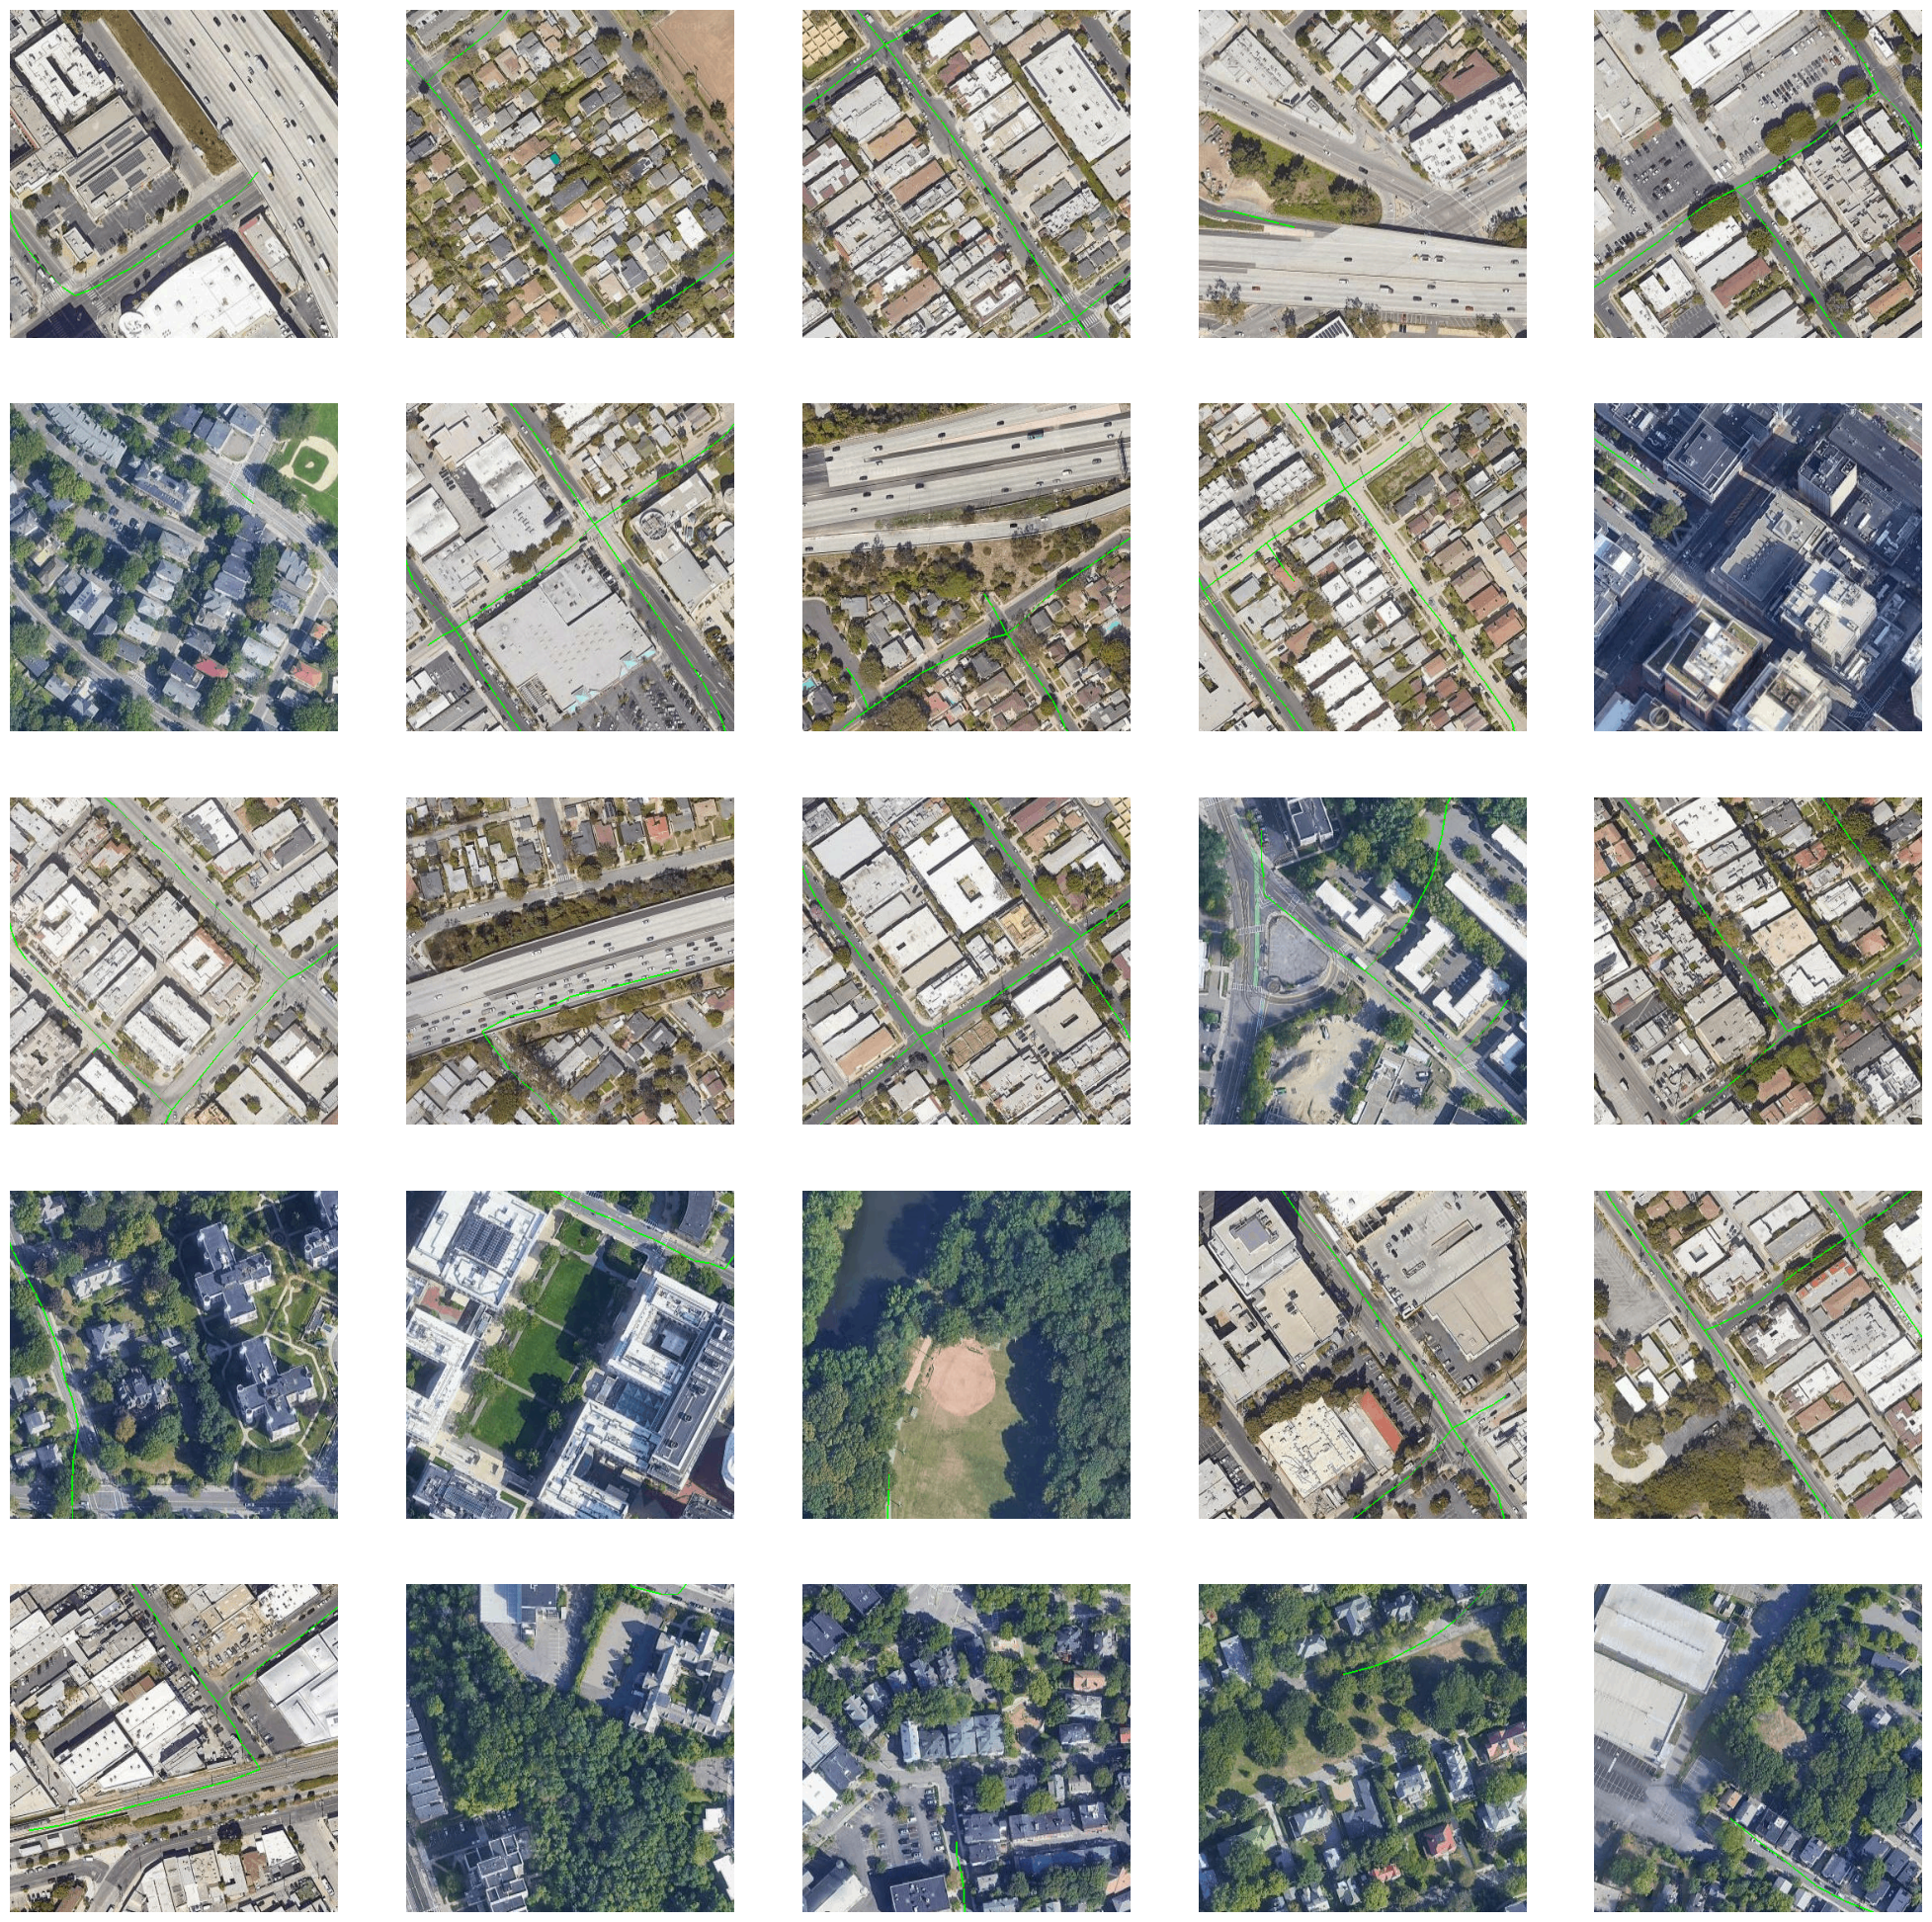

In [58]:
def get_max_indices(mask):
    (x,y) = (mask == np.max(mask)).nonzero()
    return np.stack([x,y], axis=1)


m, session = get_model()

fig, axs = plt.subplots(5, 5, figsize=(25, 25))

for i in range(25):
    # gotta choose better indices this is very naive
    indices = get_max_indices(masks[i])

    starting_locs = []
    j = 0
    while j < len(indices):
        starting_locs.append(geom.Point(indices[j][0] - 200, indices[j][1] - 200))
        j += max(len(indices) // 10, 1)


    roadtracer_img = roadtracer_infer(m, session, images[i], starting_locs)


    roadtracer_img += (np.sum(roadtracer_img, axis=-1) == 0)[:,:,None] * images[i]
    # roadtracer_img += (np.sum(roadtracer_img, axis=-1) == 0)[:,:,None] * masks[i,:,:,None]
    
    axs[i//5, i%5].imshow(roadtracer_img)
    axs[i//5, i%5].set_axis_off()
